<a href="https://colab.research.google.com/github/yuu399/Mahalanobis-anomaly-detection/blob/main/Mahalanobis_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

画像データの読み込み。
MVTecデータセットのhazelnutの画像を使用：https://www.mvtec.com/company/research/datasets/mvtec-ad/
あらかじめデータをカレントディレクトリ配下のdataフォルダに保存しておく必要がある。

In [ ]:
import pathlib
from PIL import Image
import numpy as np

hazelnut = pathlib.Path('./data/hazelnut')
train = hazelnut / 'train'
test = hazelnut / 'test'

train_images = []
test_images = []
test_labels = []    # normal: 0, abnormal: 1

for item in train.glob('**/*.png'):
  img = Image.open(str(item))
  img = img.resize((256, 256))
  #img = np.asarray(img).flatten()
  train_images.append(img)

for item in test.glob('**/*.png'):
  img = Image.open(str(item))
  img = img.resize((256, 256))
  #img = np.asarray(img).flatten()
  test_images.append(img)
  if 'good' in str(item):
    test_labels.append(0)
  else:
    test_labels.append(1)

#train_images = np.asarray(train_images)
#test_images = np.asarray(test_images)
test_labels = np.asarray(test_labels)

画像の確認

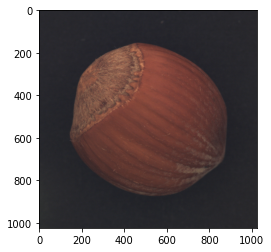

In [ ]:
import matplotlib.pyplot as plt

img_good = Image.open(str(test / 'good/000.png'))
plt.imshow(np.asarray(img_good))

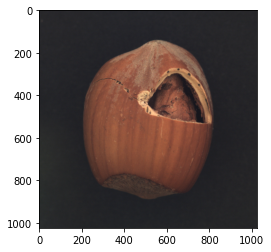

In [ ]:
img_crack = Image.open(str(test / 'crack/000.png'))
plt.imshow(np.asarray(img_crack))

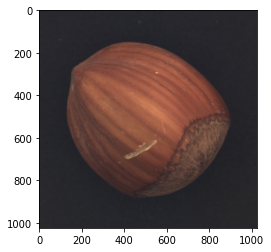

In [ ]:
img_cut = Image.open(str(test / 'cut/000.png'))
plt.imshow(np.asarray(img_cut))

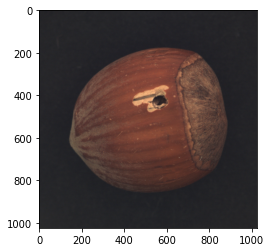

In [ ]:
img_hole = Image.open(str(test / 'hole/000.png'))
plt.imshow(np.asarray(img_hole))

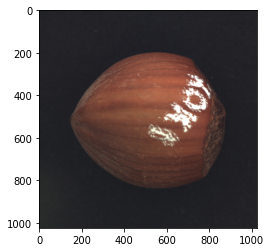

In [ ]:
img_print = Image.open(str(test / 'print/000.png'))
plt.imshow(np.asarray(img_print))

学習済みのCNNモデルを使って特徴量を抽出する。今回はEfficientNetを使用した。
https://github.com/lukemelas/EfficientNet-PyTorch

In [ ]:
%pip install efficientnet_pytorch

In [ ]:
import torch
from torchvision import transforms

from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b4')
model.eval()

import time
inference_times = []

tfms = transforms.Compose([transforms.ToTensor()])

with torch.no_grad():
  train_features = []
  for img in train_images:
    img = tfms(img).unsqueeze(0)
    start_time = time.time()
    feature = model.extract_features(img)
    feature = torch.mean(feature, [2, 3])    # global avrage pooling
    inference_times.append(time.time() - start_time)
    train_features.append(feature.detach().numpy())

  test_features = []
  for img in test_images:
    img = tfms(img).unsqueeze(0)
    start_time = time.time()
    feature = model.extract_features(img)
    feature = torch.mean(feature, [2, 3])   # global average pooling
    inference_times.append(time.time() - start_time)
    test_features.append(feature.detach().numpy())

train_features = np.concatenate(train_features, 0)
print(train_features.shape)
test_features = np.concatenate(test_features, 0)
print(test_features.shape)

inference_time = np.mean(np.asarray(inference_times))
print(f'inference time: {inference_time * 1000} [ms]')

Loaded pretrained weights for efficientnet-b4
(391, 1792)
(110, 1792)
inference time: 280.03074832543166 [ms]


マハラノビス距離を計算するためにtrainデータから母平均と母分散を推定する。
ただし、今回は (データ数)/(特徴量の次元) が無視できるほと小さくないので不偏分散では母分散をうまく推定できない。
そこでShrinkageを用いる。詳細については以下の論文を参照。
https://www.sciencedirect.com/science/article/pii/S0047259X03000964

In [ ]:
def estimate_params(input):
  # input: sample data, ndarray, shape: (n_features, n_samples)
  p = input.shape[0]
  n = input.shape[1]

  sample_mean = np.cumsum(input, axis=1)[:, -1] / n

  X = input - sample_mean[np.newaxis, :].T 

  I = np.identity(p)
  S = np.dot(X, X.T) / n    # sample covariance matrix

  m = np.trace(np.dot(S, I)) / p
  xi = S - m * I
  d_2 = np.trace(np.dot(xi, xi.T)) / p
  b_2_bar = 0
  for k in range(n):
    eta = np.dot(X[:, k], X[:, k].T) - S
    b_2_bar += np.trace(np.dot(eta, eta.T)) / p
  b_2_bar = b_2_bar / (n * n)
  b_2 = min([b_2_bar, d_2])
  a_2 = d_2 - b_2

  sigma = (b_2 * m * I + a_2 * S) / d_2    # the estimate of covariance matrix

  return sample_mean, sigma

In [ ]:
sample_mean, sigma = estimate_params(train_features.T)

テストデータに対してマハラノビス距離を計算する。

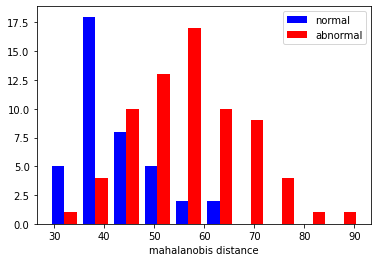

In [ ]:
from scipy.spatial import distance

sigma_inv = np.linalg.pinv(sigma)    # calculate the inverse matrix

anomaly_scores = []
for idx in range(test_features.shape[0]):
  anomaly_scores.append(distance.mahalanobis(test_features[idx], sample_mean, sigma_inv))
anomaly_scores = np.asarray(anomaly_scores)

normal_scores = anomaly_scores[test_labels==0]
abnormal_scores = anomaly_scores[test_labels==1]

plt.hist([normal_scores, abnormal_scores], color=['b', 'r'], label=['normal', 'abnormal'])
plt.xlabel('mahalanobis distance')
plt.legend()

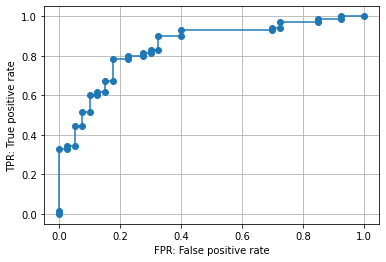

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(test_labels, anomaly_scores)

plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()